# Transfer learning (ResNet-CIFAR10) tutorial

## 초기 설정

In [1]:
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchsummary

from matplotlib import pyplot as plt
import numpy as np
import time
import copy

## 데이터 전처리

In [2]:
# 데이터 변형 함수
# 224x224로 resize
# Array -> Tensor로 변환 
# 각 채널의 분산을 0.5로 하여 정규화

transform = transforms.Compose([
    transforms.Resize(224, interpolation=2),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# 데이터 로드

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, 
                                        shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
dataset_sizes = {
    'train': len(trainset), 
    'val': len(valset), 
    'test': len(testset)
}
dataloaders = {
    'train': trainloader, 
    'val': valloader, 
    'test': testloader
}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')                                

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Files already downloaded and verified
Files already downloaded and verified


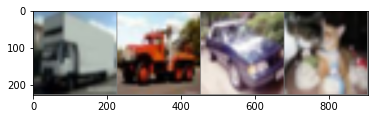

truck truck   car   cat


In [3]:
# 이미지 출력 함수
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## 모델 학습 및 평가

In [4]:
# gpu사용
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
# 모델 학습 함수
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # validation 중 최고의 성능에 대한 weights 저장
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for i, (inputs, labels) in enumerate(dataloaders[phase], 0):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)
                if i % 2000 == 1999:
                    print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000: 0.3f}')
                    running_loss = 0.0
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [6]:
# Resnet18 모델 불러오기
model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# 마지막 fc layer의 output shape를 변형
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [7]:
torchsummary.summary(model_ft, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [8]:
model_ft = train_model(model_ft, 
                       criterion=criterion,
                       optimizer=optimizer,
                       scheduler=exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------
[1, 2000] loss:  8.384
[1, 4000] loss:  6.797
[1, 6000] loss:  5.832
[1, 8000] loss:  5.136
[1, 10000] loss:  4.563
train Loss: 0.0000 Acc: 0.4474
[1, 2000] loss:  3.930
val Loss: 0.1871 Acc: 0.6584

Epoch 1/1
----------
[2, 2000] loss:  4.125
[2, 4000] loss:  3.776
[2, 6000] loss:  3.543
[2, 8000] loss:  3.260
[2, 10000] loss:  3.163
train Loss: 0.0000 Acc: 0.6913
[2, 2000] loss:  2.760
val Loss: 0.1381 Acc: 0.7647

Training complete in 22m 8s
Best val Acc: 0.764700


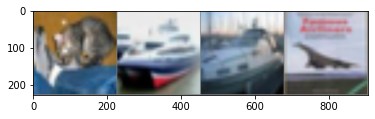

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = model_ft(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [10]:
correct = 0
total = 0 

# 테스트 시에는 학습이 필요 없으므로 no_grad()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_ft(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 76 %


- 일반 CNN 모델에서 2 epochs 학습 시, 57%의 정확도
- 성능이 향상된 모습

In [11]:
correct_pred = {class_name: 0 for class_name in classes}
total_pred = {class_name: 0 for class_name in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_ft(images)
        _, predicted = torch.max(outputs, 1)

        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 81.9 %
Accuracy for class car   is: 89.6 %
Accuracy for class bird  is: 64.4 %
Accuracy for class cat   is: 50.7 %
Accuracy for class deer  is: 77.5 %
Accuracy for class dog   is: 59.0 %
Accuracy for class frog  is: 82.8 %
Accuracy for class horse is: 83.6 %
Accuracy for class ship  is: 94.5 %
Accuracy for class truck is: 84.7 %
